In [1]:
from vqa_helper import VQA

import skimage.io as io
import matplotlib.pyplot as plt

import os
from typing import Dict, List, Optional, Tuple

from dataclasses import dataclass

import numpy as np
import random

import torch
import torch.nn as nn

from transformers import (
    AutoTokenizer, AutoFeatureExtractor, #Pre-processing
    AutoModel, #ViT
    TrainingArguments, Trainer, #Training & Eval
    logging 
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

c:\Users\karav\Desktop\ClipShot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [2]:
#Using the VQA API to create dataset
taskType    ='MultipleChoice' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='abstract_v002'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='train2015'
annFile     ='./Annotations/%s_%s_annotations.json'%(dataType, dataSubType)
quesFile    ='./Questions/%s_%s_%s_questions.json'%(taskType, dataType, dataSubType)
imgDir 		= './Images/%s/%s/' %(dataType, dataSubType)

vqa=VQA(annFile, quesFile) 

loading VQA annotations and questions into memory...
0:00:02.701373
creating index...
index created!


In [3]:
#Creating dataset
ids = list(vqa.qa.keys())
dataset = vqa.loadQA(ids)
dataset[0]

{'question_type': 'who',
 'multiple_choice_answer': 'man',
 'answers': [{'answer': 'old person',
   'answer_confidence': 'maybe',
   'answer_id': 1},
  {'answer': 'man', 'answer_confidence': 'maybe', 'answer_id': 2},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'old man', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'man', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'grandpa', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 11779,
 'answer_type': 'other',
 'question_id': 117792}

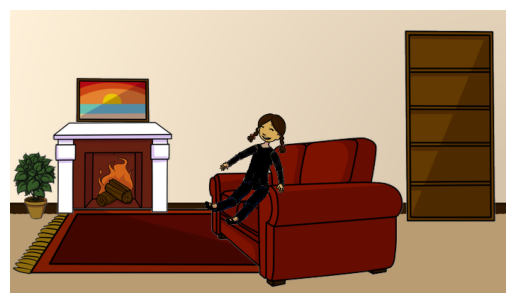

How is the girls staying warm?
fire


In [4]:
def show_example(dataset, id = None):
    if id==None:
        id = np.random.randint(len(dataset))

    imgId = dataset[id]['image_id']
    imgFilename = dataType + '_' + dataSubType + '_'+ str(imgId).zfill(12) + '.png'
    img = io.imread(imgDir + imgFilename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    qId = dataset[id]['question_id']
    q = vqa.qqa[qId]['question']
    print(q)
    ans = dataset[id]['multiple_choice_answer']
    print(ans)

show_example(dataset)

In [5]:
'''
Define a collator that will pre-process question(text) and image 
and returns tokenized text(attention mask) and featurized image(pixel values)
'''
@dataclass
class MultiModalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text = texts,
            padding = 'longest',
            return_tensors = 'pt',
            return_token_type_ids = True,
            return_attention_mask = True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text["attention_mask"].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[io.imread(image_path).convert('RGB') for image_path in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        } #Check if normalization is needed.
    
    def __call__(self, raw_batch_list):
        texts = [vqa.qqa[item['question_id']]['question'] for item in raw_batch_list]
        images = [os.path.join(imgDir, f"{dataType}_{dataSubType}_{str(item['image_id']).zfill(12)}.png") for item in raw_batch_list]
        answers = [item['multiple_choice_answer'] for item in raw_batch_list]
        # Tokenize text and preprocess images
        tokenized_texts = self.tokenize_text(texts)
        preprocessed_images = self.preprocess_images(images)

        # Merge the tokenized text and preprocessed image dictionaries
        collated_batch = {**tokenized_texts, **preprocessed_images, "answers": answers}

        return collated_batch

In [6]:
class MultiModalVQA(nn.Module):
    def __init__(self, pretrained_text_name, pretrained_image_name, num_labels = 10, intermediate_dim = 512, dropout = 0):
        super(MultiModalVQA, self).__init__()
        self.num_labels = num_labels #because idk how to do contrastive loss yet ;-;
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()

    def forward(
            self,
            input_ids,
            pixel_values,
            attention_mask,
            token_type_ids,
            answers
    ):
        encoded_text = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)

        encoded_image = self.image_encoder(pixel_values=pixel_values, return_dict=True)

        fused_output = self.fusion(
            torch.cat([encoded_text['pooler_output'], encoded_image['pooler_output']], dim=1)
        )

        logits = self.classifier(fused_output)

        out = {
            "logits": logits
        }

        if answers is not None:
            loss = self.criterion(logits, answers)
            out['loss'] = loss

        return out

In [7]:
def create_collator_and_model(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    # Initialize the correct text tokenizer and image feature extractor, and use them to create the collator
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)
    collator = MultiModalCollator(tokenizer=tokenizer, preprocessor=preprocessor)
  
    # Initialize the multimodal model with the appropriate weights from pretrained models
    model = MultiModalVQA(pretrained_text_name=text, pretrained_image_name=image).to(device)
    
    return collator, model